In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

2025-06-20 13:21:53.752848: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750425713.997294      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750425714.068681      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ⚠️ Focal Loss Function
def focal_loss(gamma=2.0, alpha=0.75):
    def loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -tf.reduce_mean(alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt))
    return loss

# ⚙️ Paths
BASE_DIR = "/kaggle/input/lungabnormalitydetectordataset/LungAbnormalityDetectorDataset(PreprocessedAugmented)"
train_dir = os.path.join(BASE_DIR, "Train")
val_dir = os.path.join(BASE_DIR, "Validation")
test_dir = os.path.join(BASE_DIR, "Test")

# 📦 Load Datasets
IMG_SIZE = (256, 256)
BATCH_SIZE = 32


In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, label_mode='binary', image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, label_mode='binary', image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, label_mode='binary', image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

# ⚖️ Class Weights to boost abnormal recall
class_weights = {0: 0.5, 1: 2.0}

Found 8910 files belonging to 2 classes.


I0000 00:00:1750425776.723532      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750425776.724255      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 790 files belonging to 2 classes.
Found 780 files belonging to 2 classes.


In [4]:
# 🔁 Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# 🧠 Model Architecture using ResNet50
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

# ⚙️ Compile with focal loss
model.compile(
    optimizer='adam',
    loss=focal_loss(gamma=2.0, alpha=0.75),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# ⏱️ Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("model_resnet50_normal_vs_abnormal.h5", save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
]

# 🚀 Initial Training
history = model.fit(train_ds, validation_data=val_ds, epochs=10,
                    class_weight=class_weights, callbacks=callbacks)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


I0000 00:00:1750425808.761286     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


279/279 ━━━━━━━━━━━━━━━━━━━━ 69s 187ms/step - accuracy: 0.7969 - auc: 0.8457 - loss: 0.1888 - val_accuracy: 0.7975 - val_auc: 0.9145 - val_loss: 0.0925 - learning_rate: 0.0010
Epoch 2/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 50s 178ms/step - accuracy: 0.8971 - auc: 0.9608 - loss: 0.0640 - val_accuracy: 0.8025 - val_auc: 0.9201 - val_loss: 0.1020 - learning_rate: 0.0010
Epoch 3/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 50s 179ms/step - accuracy: 0.9082 - auc: 0.9701 - loss: 0.0557 - val_accuracy: 0.8494 - val_auc: 0.9311 - val_loss: 0.0752 - learning_rate: 0.0010
Epoch 4/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 50s 179ms/step - accuracy: 0.9137 - auc: 0.9731 - loss: 0.0522 - val_accuracy: 0.8620 - val_auc: 0.9429 - val_loss: 0.0743 - learning_rate: 0.0010
Epoch 5/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 50s 179ms/step - accuracy: 0.9212 - auc: 0.9769 - loss: 0.0491 - val_accuracy: 0.8987 - val_auc: 0.9552 - val_loss: 0.0628 - learning_rate: 0.0010
Epoch 6/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 49s 177ms/step - accuracy: 0.9274 - 

In [5]:
# 🔓 Fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=focal_loss(gamma=2.0, alpha=0.75),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

fine_tune_history = model.fit(train_ds, validation_data=val_ds, epochs=10,
                              class_weight=class_weights, callbacks=callbacks)

Epoch 1/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 123s 333ms/step - accuracy: 0.8598 - auc: 0.9501 - loss: 0.0940 - val_accuracy: 0.9051 - val_auc: 0.9573 - val_loss: 0.0660 - learning_rate: 1.0000e-05
Epoch 2/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 88s 316ms/step - accuracy: 0.9319 - auc: 0.9823 - loss: 0.0431 - val_accuracy: 0.9089 - val_auc: 0.9654 - val_loss: 0.0714 - learning_rate: 1.0000e-05
Epoch 3/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 89s 320ms/step - accuracy: 0.9493 - auc: 0.9892 - loss: 0.0336 - val_accuracy: 0.9177 - val_auc: 0.9710 - val_loss: 0.0605 - learning_rate: 1.0000e-05
Epoch 4/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 88s 316ms/step - accuracy: 0.9579 - auc: 0.9924 - loss: 0.0285 - val_accuracy: 0.9203 - val_auc: 0.9727 - val_loss: 0.0672 - learning_rate: 1.0000e-05
Epoch 5/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 88s 317ms/step - accuracy: 0.9602 - auc: 0.9942 - loss: 0.0246 - val_accuracy: 0.9152 - val_auc: 0.9730 - val_loss: 0.0730 - learning_rate: 1.0000e-05
Epoch 6/10
279/279 ━━━━━━━━━━━━━━━━━━━━ 89s 

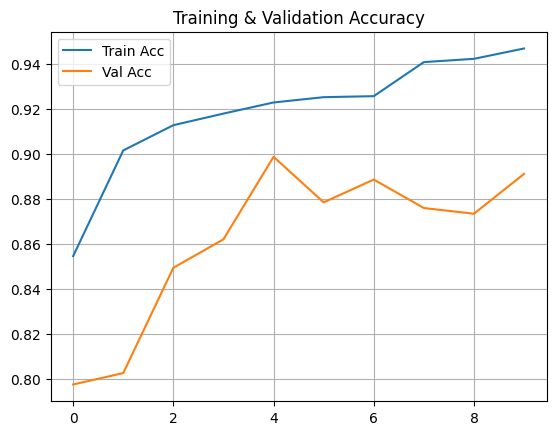

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.9547 - auc: 0.5663 - loss: 0.0324

Test Accuracy: 0.9333, AUC: 0.9813
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━

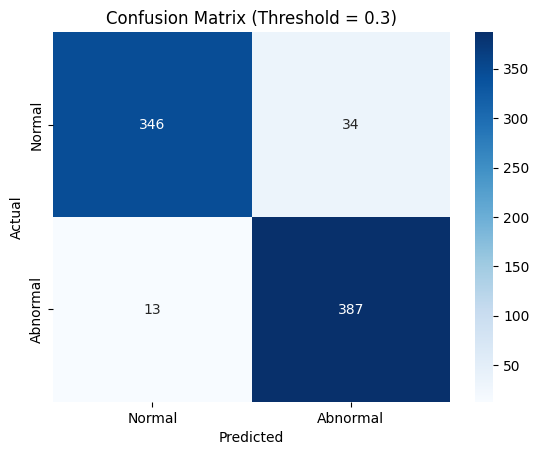

              precision    recall  f1-score   support

      Normal       0.96      0.91      0.94       380
    Abnormal       0.92      0.97      0.94       400

    accuracy                           0.94       780
   macro avg       0.94      0.94      0.94       780
weighted avg       0.94      0.94      0.94       780



In [6]:
# 📈 Plot Training History
def plot_history(h):
    plt.plot(h.history['accuracy'], label='Train Acc')
    plt.plot(h.history['val_accuracy'], label='Val Acc')
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history)

# 🧪 Evaluation
loss, acc, auc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {acc:.4f}, AUC: {auc:.4f}")

# 📊 Confusion Matrix + Report
y_true, y_pred = [], []
threshold = 0.3

for images, labels in test_ds:
    probs = model.predict(images).flatten()
    preds = (probs > threshold).astype(int)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Abnormal"],
            yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {threshold})")
plt.show()

print(classification_report(y_true, y_pred, target_names=["Normal", "Abnormal"]))

In [7]:
# 💾 Save Model
model.save("LungAbnormalityDetectorThree_ModelResNet50.h5")

# 📱 Convert to .tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("LungAbnormalityDetectorThree_ModelResNet50.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp5gcqoa__'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_175')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132544037942672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132544037943248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132544037944400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132544037945168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132544037942096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132544037944016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132544038144144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132544038146640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132544038147600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132544038144912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1325440381

W0000 00:00:1750427335.004506      35 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1750427335.004554      35 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1750427335.159510      35 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
